### Initial data analysis

Note:
1. Due to limited time, the analysis part is quickly done with Tableau)
2. The marketing campaigns part also needs additional campaign details: source, channel, impressions, click through rate, conversions, etc. So for now it is not considered as part of the first iteration.

---
**Data analysis findings:**
1. The stores are located in the same country - GDP and other macro economics data are similar for all store locations.
2. The stores seem to sell similar products with similar price range. The bigger stores with more employees tends to have higher sales volume.
3. Sales depends on the number of customers - signifies B2C market.
4. The stores also hires temporary employees during the peak sales season.
5. The average number of customers and average sales tends to increase by a significant margin just before Black Friday (November) and Christmas (December).
6. The months of Nov and Dec outperforms all other months when average sales are considered.
7. There is a trend on sales and returns. The peak average return percentage happens one month following the peak sales. And the peak percentage of promotion from the stores also happens during the return phase (Jan - Mar).
8. The destination events seems to have a positive effect on sales in general. The months when the stores have some events, the sales go significantly higher. Also they tends to happen during the holiday seasons (Oct-May)

More details in the additional analysis pdf provided alongside this notebook.

---

## Decisions taken based on the data analysis:
1. The macro economics fields will not be considered in the first iteration of the model - additonal deep dive required to make concerete conclusion on these fields and how they are affecting the overall sales.
2. Since all the stores shares the exact same pattern and there are no overlapping of sales volume (one store does not outperform another store in sales over the given time period), for now the testing will be focussed on one store (Louisville) and then the model will be trained and tested on all stores combined.
3. Customers and employees are strongly correlated with overall sales volume. So for now only customer data has been considered to make the model simpler.
4. Instead of the given holiday field which shows all the holidays, the Near_Xmas and Near_BlackFriday will be considered.

In [256]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,acf, pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly
import plotly.offline as py

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [257]:
path = "drive/MyDrive/Interview Task/TD Reply/"
raw_data = pd.read_csv(path + 'practical_test.csv')
raw_data.shape

(7140, 17)

In [258]:
raw_data.head()

,Store,Date,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Pct_Promotional,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
0,Louisville,07/01/12,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,0.5,NaN,0.02
1,Louisville,07/02/12,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,NaN,NaN,NaN
2,Louisville,07/03/12,74824.71,20100,26,0.31,356,8.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,NaN,NaN,NaN
3,Louisville,07/04/12,78523.92,20100,33,0.83,350,10.08,July In Store Credit Card Signup Discount; In ...,0,0,Yes,No,0.000047,NaN,NaN,NaN
4,Louisville,07/05/12,76445.90,20100,38,0.51,299,9.80,July In Store Credit Card Signup Discount; ID5...,0,0,No,No,0.000047,NaN,NaN,NaN


In [259]:
## The near_xmas and near_blackfriday provides valuable info on how many days before and after the actual event is

near_xmas = raw_data[raw_data['Near_Xmas']!= 0]
near_bfriday = raw_data[raw_data['Near_BlackFriday']!= 0]

#near_xmas.to_csv(path + "near_xmas.csv")
#near_bfriday.to_csv(path + "near_bf.csv")

In [260]:
# Preparing the dataset for the model according to the logic mentioned above. Only Louisville store data are considered for tesing
data = raw_data[raw_data['Store']=='Louisville']
data = data.drop(columns=['Store', 'Store_Size', 'Num_Employees', 'Marketing', 'Holiday', 'Econ_ChangeGDP', 'EconJobsChange', 'AnnualizedCPI'])

In [261]:
# Date field is object type. Should be converted into date
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date                datetime64[ns]
Sales                      float64
Returns_Pct                float64
Num_Customers                int64
Pct_On_Sale                float64
Near_Xmas                    int64
Near_BlackFriday             int64
DestinationEvent            object
Pct_Promotional            float64
dtype: object

In [262]:
data_indexed = data.set_index('Date')

# Creating a separate dataframe to show a couple of analysis
analysis_df = data[['Sales']]
analysis_df.index = data_indexed.index
analysis_df

,Sales
Date,
2012-07-01,76819.40
2012-07-02,78963.86
2012-07-03,74824.71
2012-07-04,78523.92
2012-07-05,76445.90
...,...
2014-06-10,71272.74
2014-06-11,79466.74
2014-06-12,74380.12


**Trend: There seems to be no increasing or decresing trend in our data**

Text(0.5, 1.0, 'Trend of the Time Series')

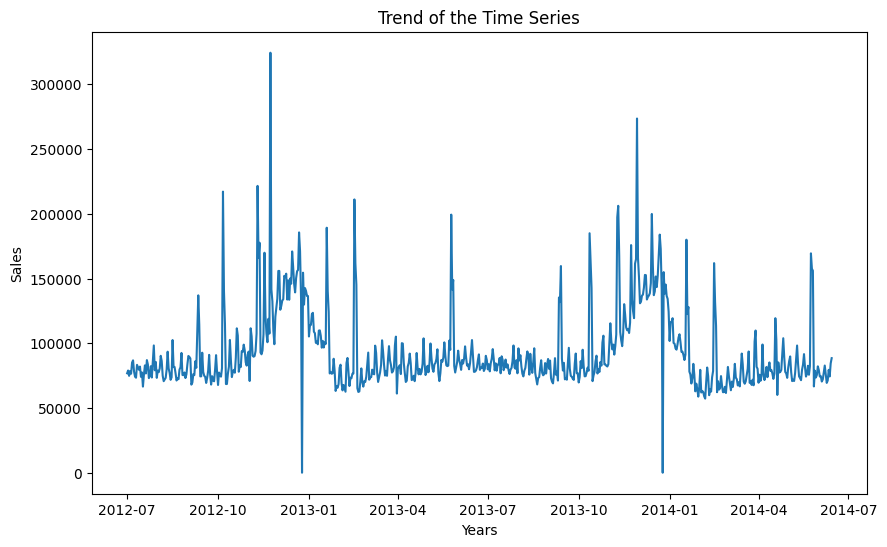

In [263]:
plt.figure(figsize= (10,6))
plt.plot(analysis_df)
plt.xlabel('Years')
plt.ylabel('Sales')
plt.title('Trend of the Time Series')

We have seen in our previous data analysis that a strong seasonality exists, following stats model seasonal decompose is confirming the same.

<Axes: title={'center': 'Seasonality of the Time Series'}, xlabel='Month', ylabel='Sales'>

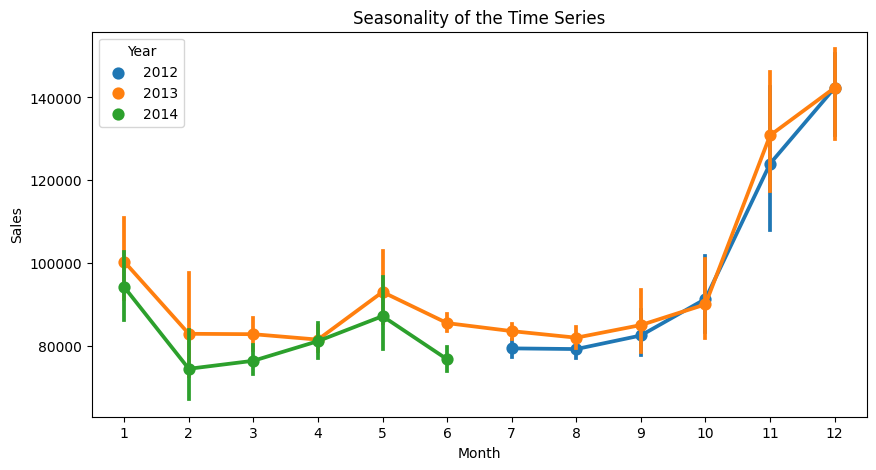

In [264]:
# Seasonality
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_temp = analysis_df.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,5))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Sales',hue='Year',data=df_temp)

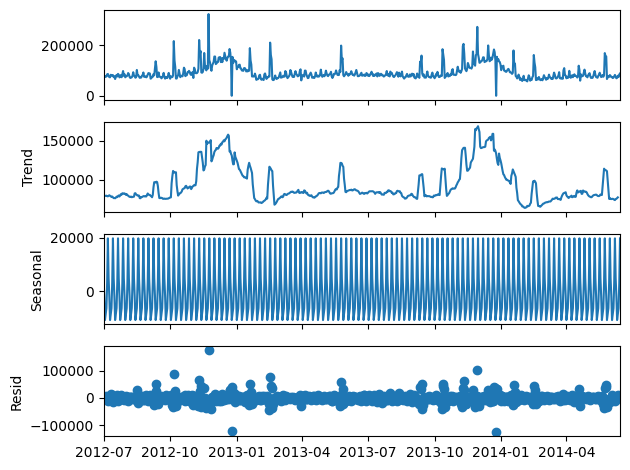

In [265]:
# An additive model is linear where changes over time are consistently made by the same amount.
# A linear trend is a straight line.
# A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
# y(t) = Level + Trend + Seasonality + Noise

decomposition = sm.tsa.seasonal_decompose(analysis_df, model='additive')
fig = decomposition.plot()

In [266]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()

    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('No of Air Passengers')
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')
    plt.legend()
    plt.show()

    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

It's clear from the previous analysis that we have seasonality in the data, the stationary test with Rolling statistic and Dickey Fuller test confirms it. P value is more than the normal thresold.

Options:
We can wither make our dataset stationary for the stationary models or use Prophet or Sarimax which can work with seasonality data. For this example, we will proceed with the later option-

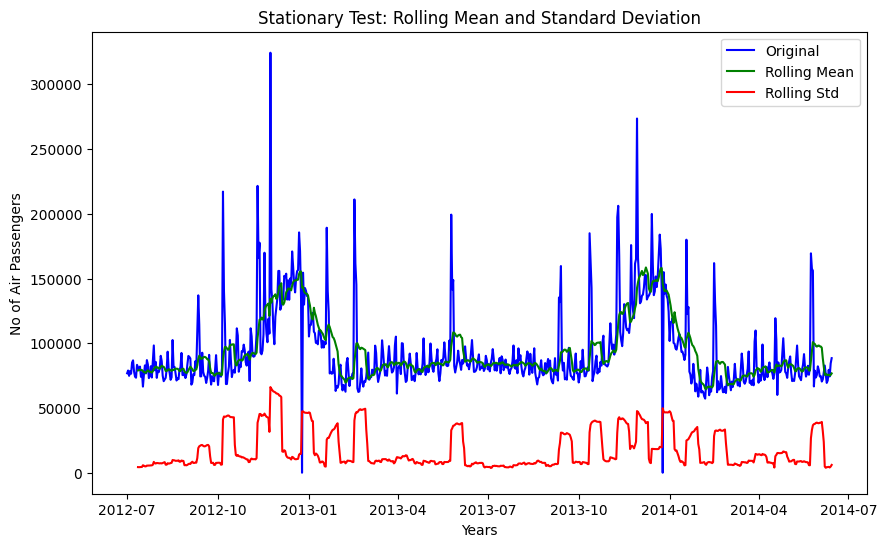

Results of Dickey-Fuller Test
Test Statistic                  -2.685905
p-value                          0.076509
#Lags Used                      13.000000
Number of Observations Used    700.000000
Critical Value (1%)             -3.439726
Critical Value (5%)             -2.865678
Critical Value (10%)            -2.568973
dtype: float64


In [267]:
stationarity_test(analysis_df)

## Using Prophet
The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

In [268]:
model_daily = Prophet(weekly_seasonality=False)
model_weekly = Prophet(weekly_seasonality=False)
model_all_weekly = Prophet(weekly_seasonality=False)

def train_model(data, regressors, model):
  # Additional features which improve forecast performance
  # In future, to make forecast with these regressors, we need to figure out how to have them before, maybe through additional forecasts
  if model == 'daily':
    model = model_daily
  elif model == 'weekly':
    model = model_weekly
  else:
    model = model_all_weekly

  if regressors == 1:
    model.add_regressor('Returns_Pct')
    model.add_regressor('Num_Customers')
    model.add_regressor('Pct_On_Sale')
    model.add_regressor('Near_Xmas')
    model.add_regressor('Near_BlackFriday')
    model.add_regressor('Pct_Promotional')
  elif regressors == 2:
    model.add_regressor('Near_Xmas')
    model.add_regressor('Near_BlackFriday')
  else:
    model.add_regressor('Store_enc')  # This extra store regressor is for the dataset that has all stores
    model.add_regressor('Near_Xmas')
    model.add_regressor('Near_BlackFriday')


  # Custom seasonlity input for the model - high sales month
  model.add_seasonality(name='monthly_on_season', period=30.5, fourier_order=5, condition_name='on_season')
  model.add_seasonality(name='monthly_off_season', period=30.5, fourier_order=5, condition_name='off_season')
  # Fit
  model.fit(data)
  print('Successfully trained!')

def forecast(data):
  forecast_df = model.predict(data)
  # summarize the forecast
  print(forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
  model.plot(forecast_df)
  model.plot_components(forecast_df)
  return forecast_df

## Adding custom seasonality for the model
def is_high_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 10 or date.month < 2)

### Forecast on Louiville - Daily granularity

DEBUG:cmdstanpy:input tempfile: /tmp/tmp00v_gztv/5khdk9c4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp00v_gztv/ukpq9wuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37847', 'data', 'file=/tmp/tmp00v_gztv/5khdk9c4.json', 'init=/tmp/tmp00v_gztv/ukpq9wuu.json', 'output', 'file=/tmp/tmp00v_gztv/prophet_modelm__ta8il/prophet_model-20230913134505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:45:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:45:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Successfully trained!
          ds           yhat     yhat_lower     yhat_upper
0 2013-11-12  123133.148518  114476.457162  132887.402885
1 2013-11-13   90370.002776   81764.646263   98911.664288
2 2013-11-14   65533.357039   56254.911749   74285.376495
3 2013-11-15   63742.596542   54320.457784   72803.261563
4 2013-11-16   81981.576775   72562.341014   91097.134794


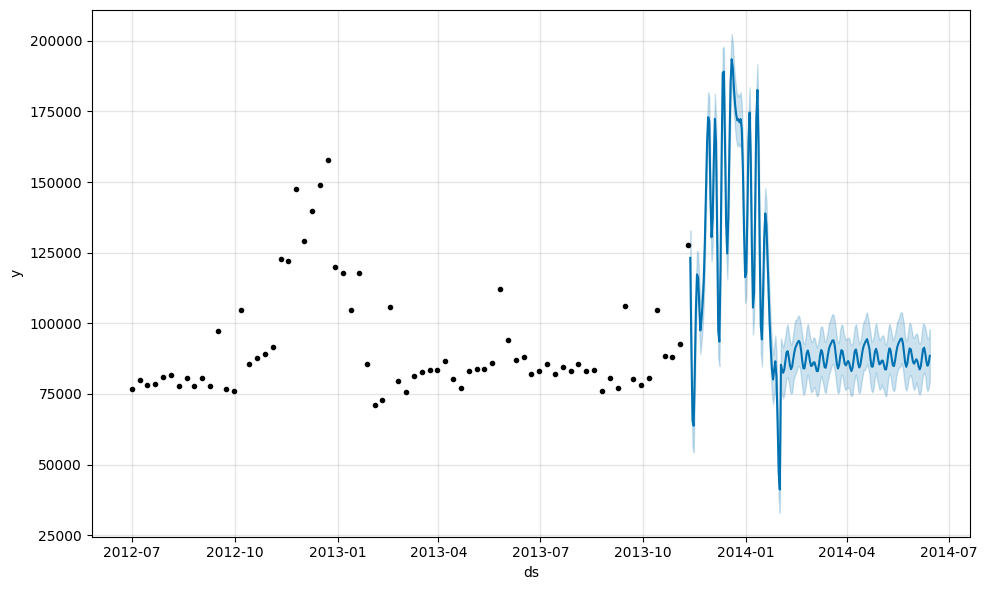

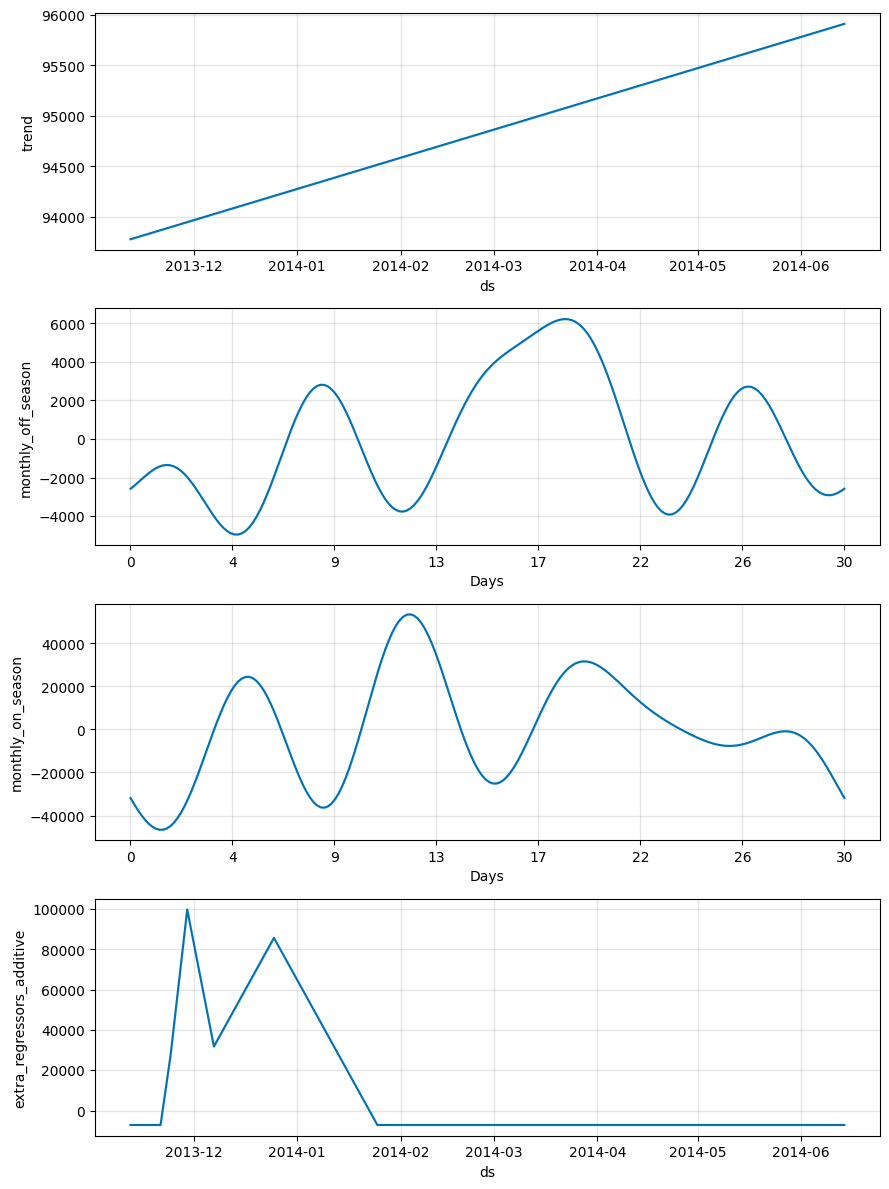

In [269]:
data_prophet_daily = data.copy()
data_prophet_daily = data_prophet_daily.rename(columns={'Date': 'ds', 'Sales': 'y'})
data_prophet_daily.dropna(inplace=True)

data_prophet_daily['on_season'] = data_prophet_daily['ds'].apply(is_high_season)
data_prophet_daily['off_season'] = ~data_prophet_daily['ds'].apply(is_high_season)

# Splitting the data into train and test to try out an in-sample forecast
train_d_df, test_d_df = train_test_split(data_prophet_daily, test_size=0.3, shuffle=False)

# Training
train_model(train_d_df, 1, 'daily')
# Forecast
forecast_daily = forecast(test_d_df)

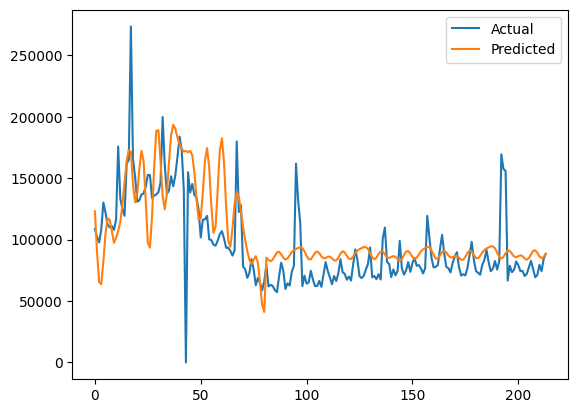

MAE: 20101.521


In [270]:
y_true = test_d_df['y'].values
y_pred = forecast_daily['yhat'].values

# Plotting actual vs forecasted
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculating Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

### Forecast on Louiville - Weekly granularity

The forecast training and test performance on weekly granular data seems to be better than the daily.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp00v_gztv/bidhermu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp00v_gztv/dbklgz6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69861', 'data', 'file=/tmp/tmp00v_gztv/bidhermu.json', 'init=/tmp/tmp00v_gztv/dbklgz6g.json', 'output', 'file=/tmp/tmp00v_gztv/prophet_model8d4vs6wg/prophet_model-20230913134507.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:45:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:45:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Successfully trained!
          ds           yhat     yhat_lower     yhat_upper
0 2013-11-17  104652.717302   95911.716868  113436.217899
1 2013-11-24   89752.125826   81368.303888   97950.239189
2 2013-12-01  123120.212262  113817.841450  132178.880100
3 2013-12-08  109163.208462  100909.335691  118230.002239
4 2013-12-15  115734.583229  107148.076854  124545.752937


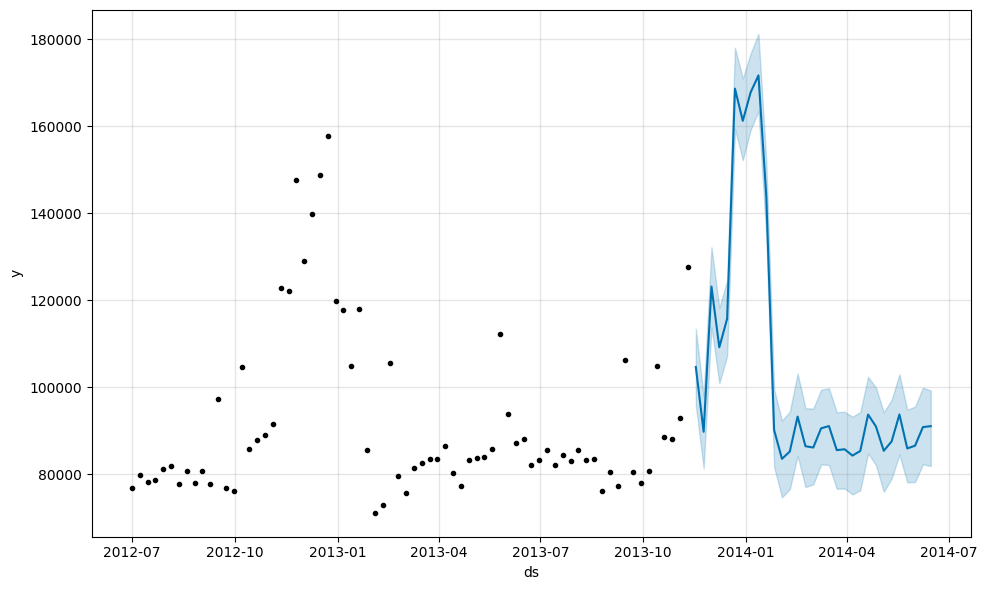

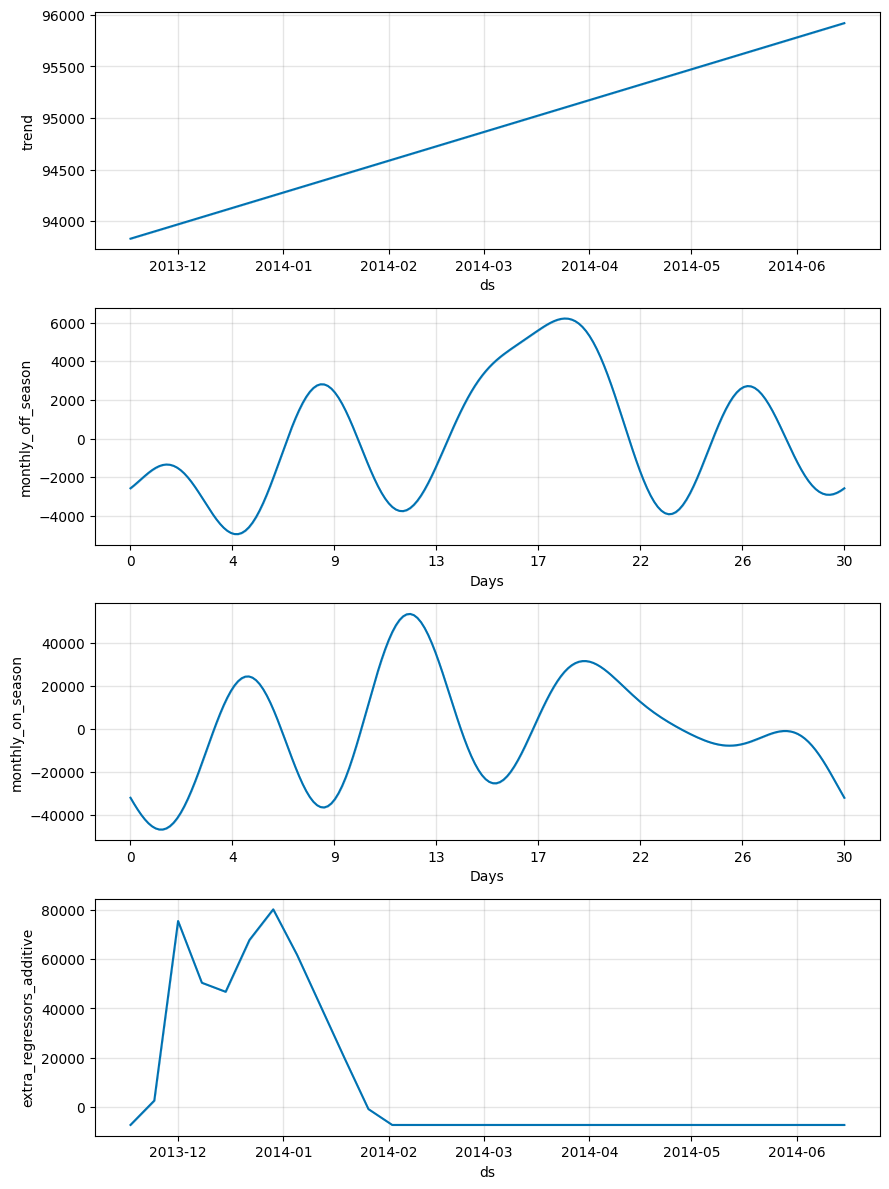

In [271]:
data_prophet_weekly = data.copy()
data_prophet_weekly = data_prophet_weekly.rename(columns={'Date': 'ds', 'Sales': 'y'})

## Switching the granularity of the dataset to weekly
data_prophet_weekly = data_prophet_weekly.groupby(pd.Grouper(key='ds', freq='W')).mean().reset_index()
data_prophet_weekly.dropna(inplace=True)

data_prophet_weekly['on_season'] = data_prophet_weekly['ds'].apply(is_high_season)
data_prophet_weekly['off_season'] = ~data_prophet_weekly['ds'].apply(is_high_season)

# Splitting the data into train and test to try out an in-sample forecast
train_w_df, test_w_df = train_test_split(data_prophet_weekly, test_size=0.3, shuffle=False)

# Training without the additional regressors
train_model(train_w_df, 2, 'weekly')
# Forecast
forecast_weekly = forecast(test_w_df)

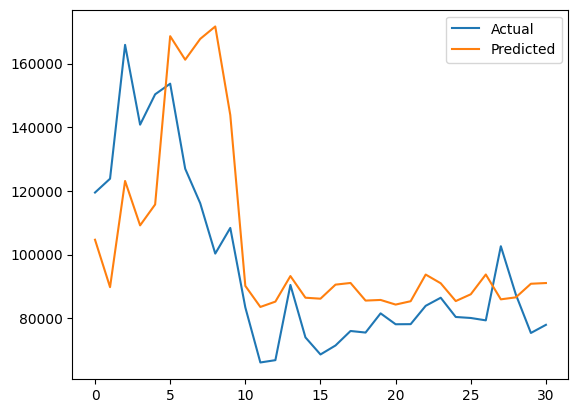

MAE: 19038.999


In [272]:
# calculate MAE between expected and predicted values for test set
y_true = test_w_df['y'].values
y_pred = forecast_weekly['yhat'].values

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

### Forecast on all stores -  weekly granularity

DEBUG:cmdstanpy:input tempfile: /tmp/tmp00v_gztv/iyhdkhnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp00v_gztv/bsfj3ncp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37341', 'data', 'file=/tmp/tmp00v_gztv/iyhdkhnb.json', 'init=/tmp/tmp00v_gztv/bsfj3ncp.json', 'output', 'file=/tmp/tmp00v_gztv/prophet_modelotoiavhe/prophet_model-20230913134515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:45:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:45:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Successfully trained!
          ds           yhat     yhat_lower     yhat_upper
0 2013-11-12  123133.148518  114024.985547  132320.423935
1 2013-11-12  123133.148518  114216.616470  132411.052976
2 2013-11-12  123133.148518  114490.731740  131738.817135
3 2013-11-12  123133.148518  113521.830493  131524.893965
4 2013-11-12  123133.148518  113491.843039  132017.755378


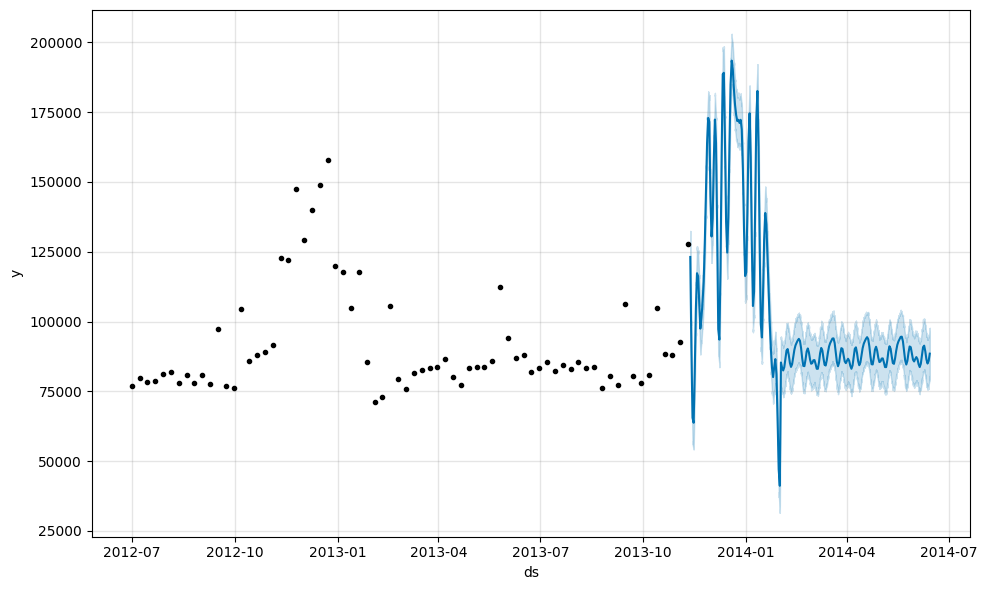

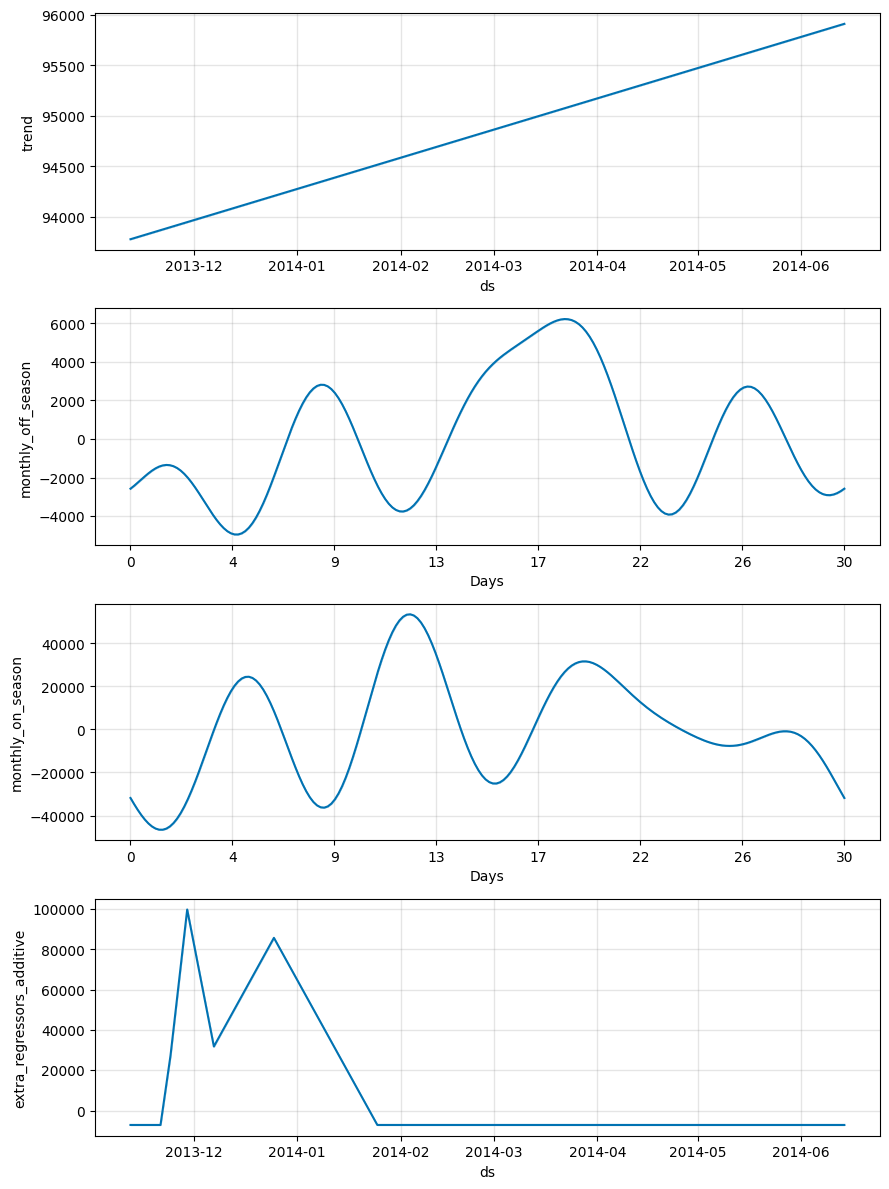

In [273]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data_all_stores = raw_data.drop(columns=['Store_Size', 'Num_Employees', 'Marketing', 'Holiday', 'Econ_ChangeGDP', 'EconJobsChange', 'AnnualizedCPI'])
data_all_stores = data_all_stores.rename(columns={'Date': 'ds', 'Sales': 'y'})
data_all_stores['on_season'] = data_all_stores['ds'].apply(is_high_season)
data_all_stores['off_season'] = ~data_all_stores['ds'].apply(is_high_season)

train_all_df = data_all_stores.head(1)
train_all_df = train_all_df.iloc[0:0]
test_all_df = data_all_stores.head(1)
test_all_df = test_all_df.iloc[0:0]

data_all_stores = data_all_stores.groupby('Store')

for stores in data_all_stores.groups:
    group = data_all_stores.get_group(stores)
    train_df, test_df =  train_test_split(group, test_size=0.3, shuffle=False)
    train_all_df = train_all_df.append(train_df)
    test_all_df = test_all_df.append(test_df)

train_all_df['Store_enc'] = le.fit_transform(train_all_df['Store'])

# Training
train_model(train_all_df, 3, 'all')
# Forecast
forecast_all_weekly = forecast(test_all_df)

In [274]:
## Adding columns Store and actual y to the forecast outcome df for plots
test_all_df.reset_index(drop=True, inplace=True)
store_info = test_all_df[['Store', 'y']]
forecast_all_weekly = pd.concat([forecast_all_weekly, store_info], axis=1)

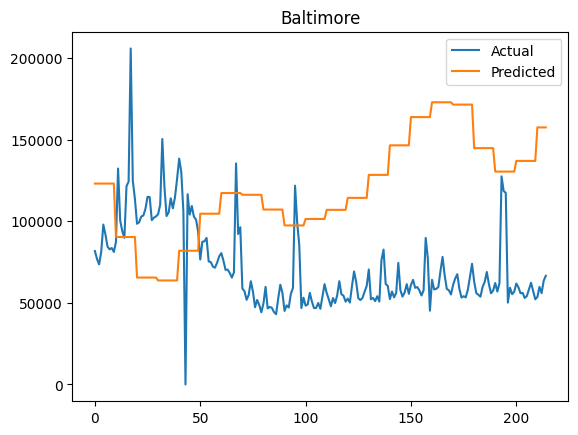

MAE: 61495.749


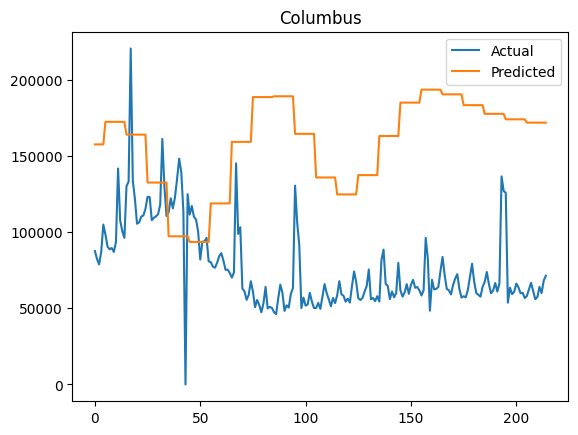

MAE: 84891.204


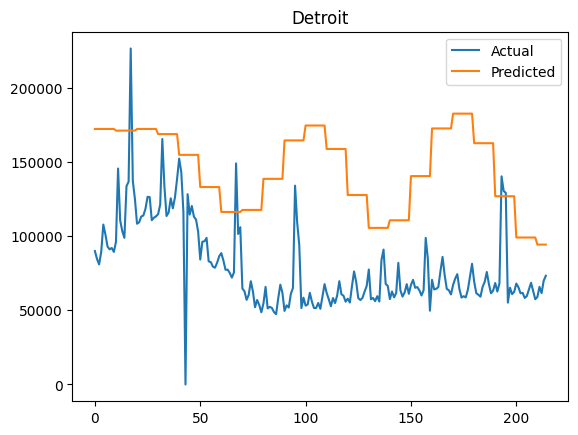

MAE: 66949.708


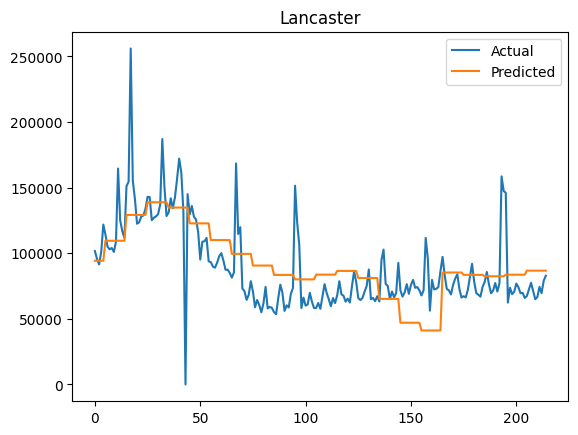

MAE: 19043.090


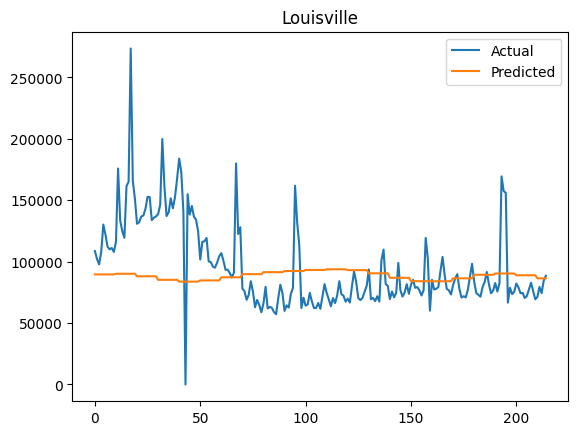

MAE: 26579.264


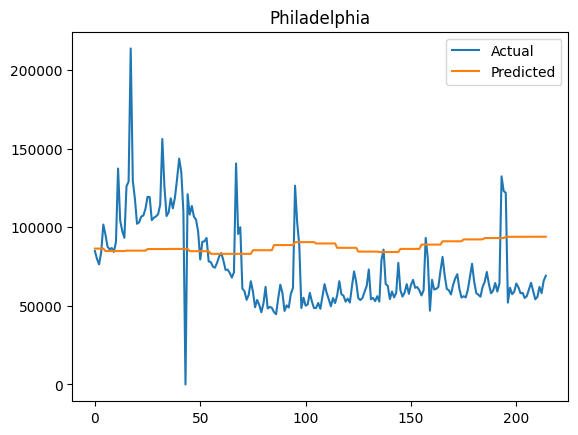

MAE: 27266.438


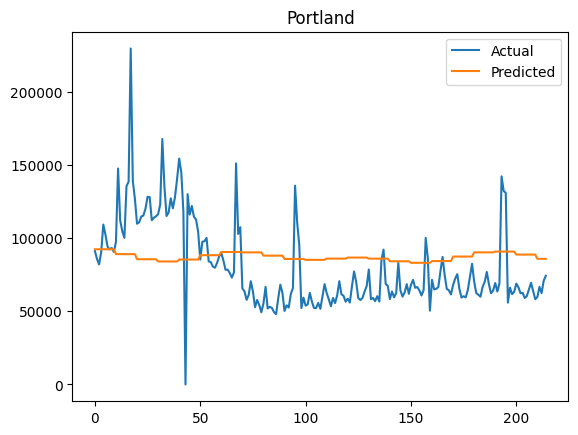

MAE: 25160.154


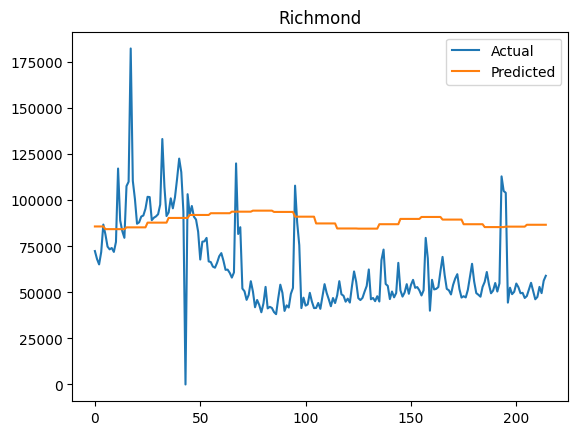

MAE: 30692.716


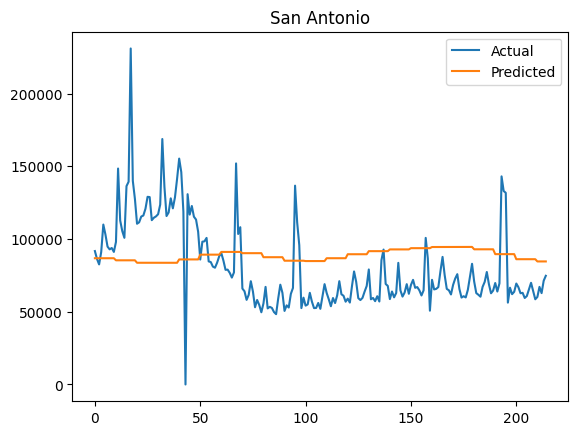

MAE: 27324.231


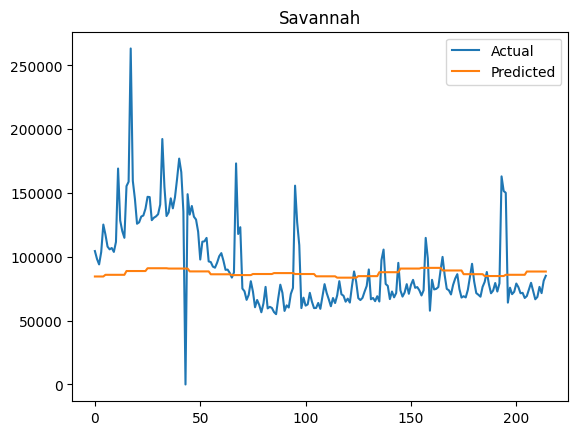

MAE: 24489.803


In [275]:
# Plot forecast for each store

forecast_grouped = forecast_all_weekly.groupby('Store')

for stores in forecast_grouped.groups:
    group = forecast_grouped.get_group(stores)
    y_true = group['y'].values
    y_pred = group['yhat'].values

    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(group.Store.iloc[0])
    plt.legend()
    plt.show()

    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: %.3f' % mae)

### Final discussion
Due to time limitations, it was not possible to complete the solution as requested. But here are my final thoughts on how to complete and improve in the future.

**Part 0: Data quality, manipulation and visualization:**
1. The EDA part was done in Tableau to save time on understanding the dataset, the results are provided alongside this notebook in a pdf file. The main takeaways has been discussed at the beginning of this notebook.
2. In the EDA part, a more in depth look on the macro economics and marketing campaign data could possible bring out more information and newer pattern.

**Part 1: Time series analysis:**
1. The timeseries analysis, although shown in EDA part, has been done additionally here. Trend, Seasonality and Stationarity check (using rolling statistic and Dickey Fuller test) has been performed to prove the EDA hypothesis.
2. Based on this, FB Prophet model has been chosen, to deal with strong seasonal effects and sales outliers especially in the month of Jan 2013.
3. In future, the FB prophet model could be improved with fine tuning (custom holidys, special events, macro economics) and other models like SARIMA could be tried.

**Part 2: Forecasting:**
1. The testing is focussed on the top store by size and sales - Louisville, due to time limitations. Later down the notebook, forecast has been done on all stores.
The data set was split into two parts for training and validation (70:30).
2. The FB prophet model was trained on daily as well as weekly granularity, the daily forecast was too abprupt. The weekly granularity made more sense in this case.
3. For this iteration, the Near_Xmas and Near_BlackFriday were considered as additional regressors to the model, since those could be easily calculated for the upcoming years. But for future iterations, adding the other regressors as shown in the code will yield a more accurate forecast. But those need to be produced first through additional forecasting models.
4. The model with just the two additional regressors as mentioned in the previous point performed decently and can be shown to the customer as a Prototype.
5. The comparison of forecast vs Actual on the test data shows it is close, although the Mean Absolute Error is high. This needs to be looked into in the future iterations, whether some other form of model validation / error calculation techniques could be used or not.
6. <font color='red'>** When forecast training was done for an individual store, it seems quite close to acutual. But when the forecast training was performed on a single dataset containing all stores, even with Store as a model regressor, the outcome was quite poor. So in future, individual dataset could be prepared for each store and training could be done separately**</font>

**Part 3: Conclusion and business insight**
1. Apart from the data anaylsis findings mentioned at the start of the notebook, it is worth noting that during summer months (February, May, September & October, there are sales spikes. Maybe there is demand apart from BlackFriday and Christmas sales, and the marketing offers and reach could be adjusted to push sales during those off season months.
2. So far the first preliminary analysis does not show strong correlation between economic situation and sales, but in the future, the customer could adjust offers based on the economic situation.
3. The smaller the store, the lesser the number of employees, the lesser the sales. Without looking into geographical and population data, it seems that the larger stores tends to sell more products. So the smaller stores could be given some light.

**Part 4: Scalability and productization**
1. Assuming that the company in this case has a datawarehouse or lakehouse in place, a weekly/monthly ETL job could pull all the necessary data and transform and store it in a table. This could be done in serverless cloud provided solutions like AWS Glue or through could native solutions like DataBricks or even in python using a scheduler.
2. For the model training and production, Sagemaker could be used if it is in AWS. For other clouds, their ML solutions could come in handy, assuming only 1 DataScientist is working on the project without the support of ML Ops and Data Engineers.
